# Postulación a NeuralWorks
**Data Science Challenge**

En el siguiente Notebook se presenta el desarrollo del análisis y respuestas al desafío.

**Felipe Uribe Pizarro**
<br>
10/01/2023

## Preparación
Se importan librerías y se cargan los datos desde el archivo .csv

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import catboost
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import shap

In [2]:
df_raw = pd.read_csv('dataset_SCL.csv', low_memory=False)
df = df_raw.copy(deep=True)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


De la muestra del DataFrame cargado, se observan sólo columnas categóricas, a excepción de las dos columnas de fecha. Se le da el formato correspondiente a las columnas.

In [3]:
date_vars = ['Fecha-I', 'Fecha-O']

for column in df.columns:
    if column in date_vars:
        df[column] = pd.to_datetime(df[column])
    else:
        df[column] = df[column].astype('category')

df.dtypes

Fecha-I      datetime64[ns]
Vlo-I              category
Ori-I              category
Des-I              category
Emp-I              category
Fecha-O      datetime64[ns]
Vlo-O              category
Ori-O              category
Des-O              category
Emp-O              category
DIA                category
MES                category
AÑO                category
DIANOM             category
TIPOVUELO          category
OPERA              category
SIGLAORI           category
SIGLADES           category
dtype: object

A continuación, se realiza una inspección rápida de los datos.

In [4]:
df.describe(include='all',datetime_is_numeric=True)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,68206.0,68206.0,68206.0,68206,68206,68206,68206,68206
unique,NaN,584,1,64,30,NaN,861,1,63,32,31.0,12.0,2.0,7,2,23,1,62
top,NaN,174,SCEL,SCFA,LAN,NaN,174,SCEL,SCFA,LAN,20.0,12.0,2017.0,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,NaN,686,68206,5787,37611,NaN,649,68206,5786,20988,2290.0,6356.0,68204.0,10292,36966,40892,68206,6335
mean,2017-07-05 12:11:25.320059648,NaN,NaN,NaN,NaN,2017-07-05 12:20:31.971380992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2017-03-31 12:41:15,NaN,NaN,NaN,NaN,2017-03-31 12:51:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2017-07-10 05:30:00,NaN,NaN,NaN,NaN,2017-07-10 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2017-10-08 11:18:45,NaN,NaN,NaN,NaN,2017-10-08 11:19:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2018-01-01 00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se observa lo siguiente:
- Sólo falta un dato en la columna Vlo-O. Todas las demás columnas tienen 68206 datos, sin faltantes.
- Todos los datos corresponden a vuelos programados durante el 2017, con origen Santiago.
- Des-I no necesariamente coincide con Des-O, ya que existen distintos valores únicos. Esto aplica también para Vlo-I/Vlo-O y Emp-I/Emp-O.
- Existen menos valores únicos de OPERA que de Emp-I/Emp-O, por lo que cada operador puede tener más de un código de empresa.
<br>

A continuación, se verifican los destinos que no coinciden y las empresas por operador.

In [5]:
df[df['Des-I'].astype(str)!=df['Des-O'].astype(str)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,17,1,2017,Martes,N,Sky Airline,Santiago,Temuco
7290,2017-02-15 06:25:00,11,SCEL,SCTE,SKU,2017-02-15 06:25:00,11,SCEL,SCQP,SKU,15,2,2017,Miercoles,N,Sky Airline,Santiago,Temuco
7520,2017-02-27 06:40:00,71,SCEL,SCIE,SKU,2017-02-27 09:07:00,71,SCEL,SCQP,SKU,27,2,2017,Lunes,N,Sky Airline,Santiago,Temuco
8456,2017-02-15 06:10:00,57,SCEL,SCTE,LAN,2017-02-15 06:12:00,57,SCEL,SCQP,LAN,15,2,2017,Miercoles,N,Grupo LATAM,Santiago,Temuco
12787,2017-03-18 06:25:00,11,SCEL,SCTE,SKU,2017-03-18 06:29:00,11,SCEL,SCQP,SKU,18,3,2017,Sabado,N,Sky Airline,Santiago,Temuco
12823,2017-03-22 12:50:00,17,SCEL,SCBA,SKU,2017-03-22 12:48:00,17,SCEL,SCTE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Puerto Montt
16169,2017-03-13 23:20:00,532,SCEL,KJFK,LAN,2017-03-14 01:35:00,1346,SCEL,KMIA,LAN,14,3,2017,Martes,I,Grupo LATAM,Santiago,Miami
16937,2017-03-22 17:00:00,1446,SCEL,SEGU,LAN,2017-03-22 17:11:00,1361,SCEL,SABE,LAN,22,3,2017,Miercoles,I,Grupo LATAM,Santiago,Buenos Aires
18293,2017-04-14 18:40:00,25,SCEL,SCTE,SKU,2017-04-14 18:48:00,25,SCEL,SCQP,SKU,14,4,2017,Viernes,N,Sky Airline,Santiago,Temuco
20444,2017-04-14 22:00:00,289,SCEL,SCTE,LAN,2017-04-14 22:01:00,289,SCEL,SCCI,LXP,14,4,2017,Viernes,N,Grupo LATAM,Santiago,Punta Arenas


In [6]:
np.sort(pd.unique(df['OPERA'].astype(str)+'-'+df['Emp-I'].astype(str)+'-'+df['Emp-O'].astype(str)))

array(['Aerolineas Argentinas-ARG-ARG', 'Aerolineas Argentinas-ARG-AUT',
       'Aeromexico-AMX-AMX', 'Air Canada-ACA-ACA', 'Air France-AFR-AFR',
       'Alitalia-AZA-AZA', 'American Airlines-AAL-AAL', 'Austral-AUT-ARG',
       'Austral-AUT-AUT', 'Avianca-AVA-AVA', 'Avianca-AVA-LRC',
       'Avianca-AVA-TPU', 'British Airways-BAW-BAW', 'Copa Air-CMP-CMP',
       'Delta Air-DAL-DAL', 'Gol Trans-GLO-GLO', 'Grupo LATAM-DSM-DSM',
       'Grupo LATAM-LAN-DSM', 'Grupo LATAM-LAN-LAN',
       'Grupo LATAM-LAN-LNE', 'Grupo LATAM-LAN-LPE',
       'Grupo LATAM-LAN-LXP', 'Grupo LATAM-LAP-LAP',
       'Grupo LATAM-LNE-LNE', 'Grupo LATAM-LPE-LPE',
       'Grupo LATAM-LXP-LXP', 'Grupo LATAM-TAM-LAP',
       'Grupo LATAM-TAM-TAM', 'Iberia-IBE-IBE', 'JetSmart SPA-JAT-JAT',
       'K.L.M.-KLM-KLM', 'Lacsa-LRC-LRC', 'Latin American Wings-JMR-JMR',
       'Latin American Wings-LAW-48O', 'Latin American Wings-LAW-56R',
       'Latin American Wings-LAW-JMR', 'Oceanair Linhas Aereas-ONE-ONE',
       'Plus Ul

Tras la verificación, se observa:
- Sólo 28 vuelos cambiaron su destino. Esto se se podría deber a alguna emergencia o excepción mayor.
- SIGLADES corresponde a la ciudad del aeropuerto Des-O. Por ejemplo, la fila 62651 tenía destino original Sydney, pero aterrizó en Melbourne.
- Se confirma que cada operador puede tener más de un código de empresa.

## Pregunta 1
**¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?**
<br>

Para responder la pregunta, se procede a graficar la cuenta de observaciones por cada categoría. Se define una función de utilidad y se comienza con las categorías temporales.

In [7]:
def percentage_above_bar_relative_to_xgroup(ax, font_size):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(all_heights[0])
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=font_size, ha='center', va='bottom')

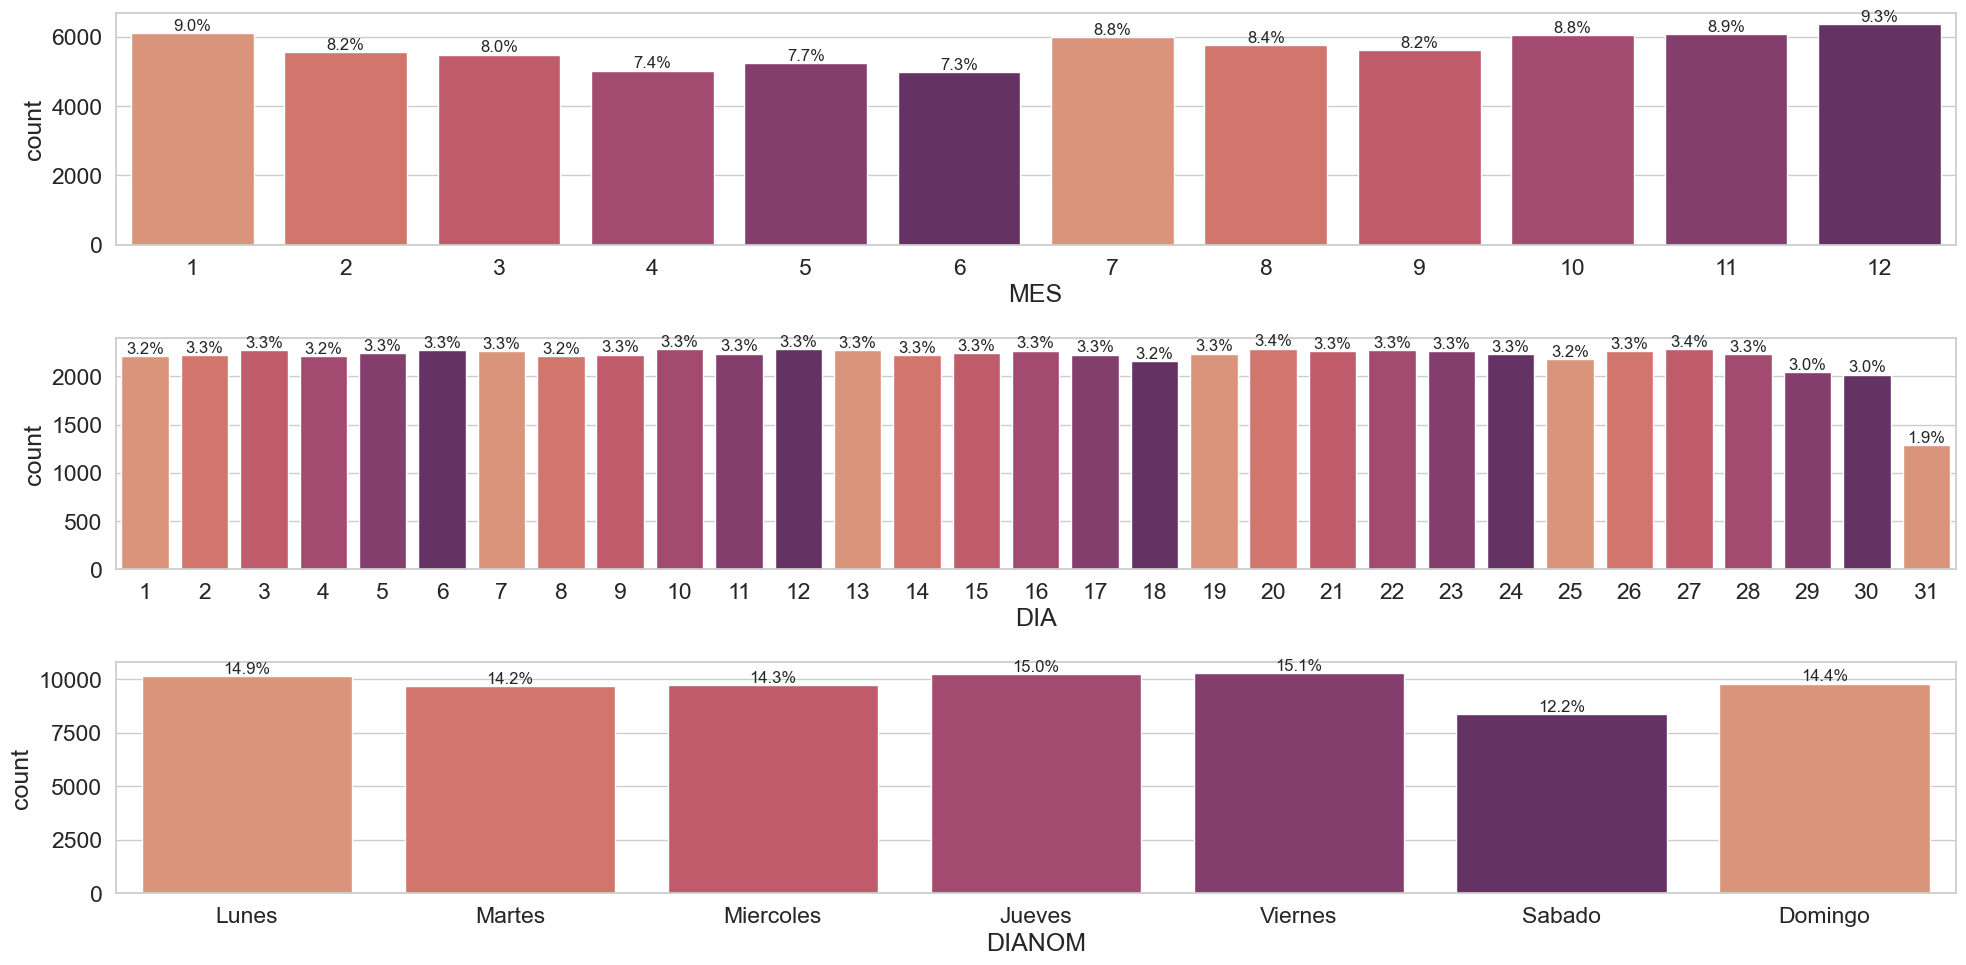

In [8]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid", font_scale=1.5)

date_categorical = ['MES','DIA','DIANOM']

plt.figure()
i = 0
for date_cat in date_categorical:
    plt.subplot(len(date_categorical), 1, 1 + i)
    if date_cat == 'DIANOM':
        order = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo']
        ax = sns.countplot(data=df, x=date_cat,palette = sns.color_palette("flare"), order = order)
    else: ax = sns.countplot(data=df, x=date_cat,palette = sns.color_palette("flare"))
    percentage_above_bar_relative_to_xgroup(ax,12)
    i += 1
plt.tight_layout()

A grandes rasgos se observa una distribución aproximadamente uniforme, salvo por:
- Una baja de cantidad de vuelos durante el Q2.
- Una ligera baja en los últimos días del mes (29, 30). Lógicamente, el día 31 posee considerablemente menos observaciones al no estar presente en todos los meses.
- Una baja en los días Sábado.

Se continua con las categorías de las aerolíneas (empresas/operadores).

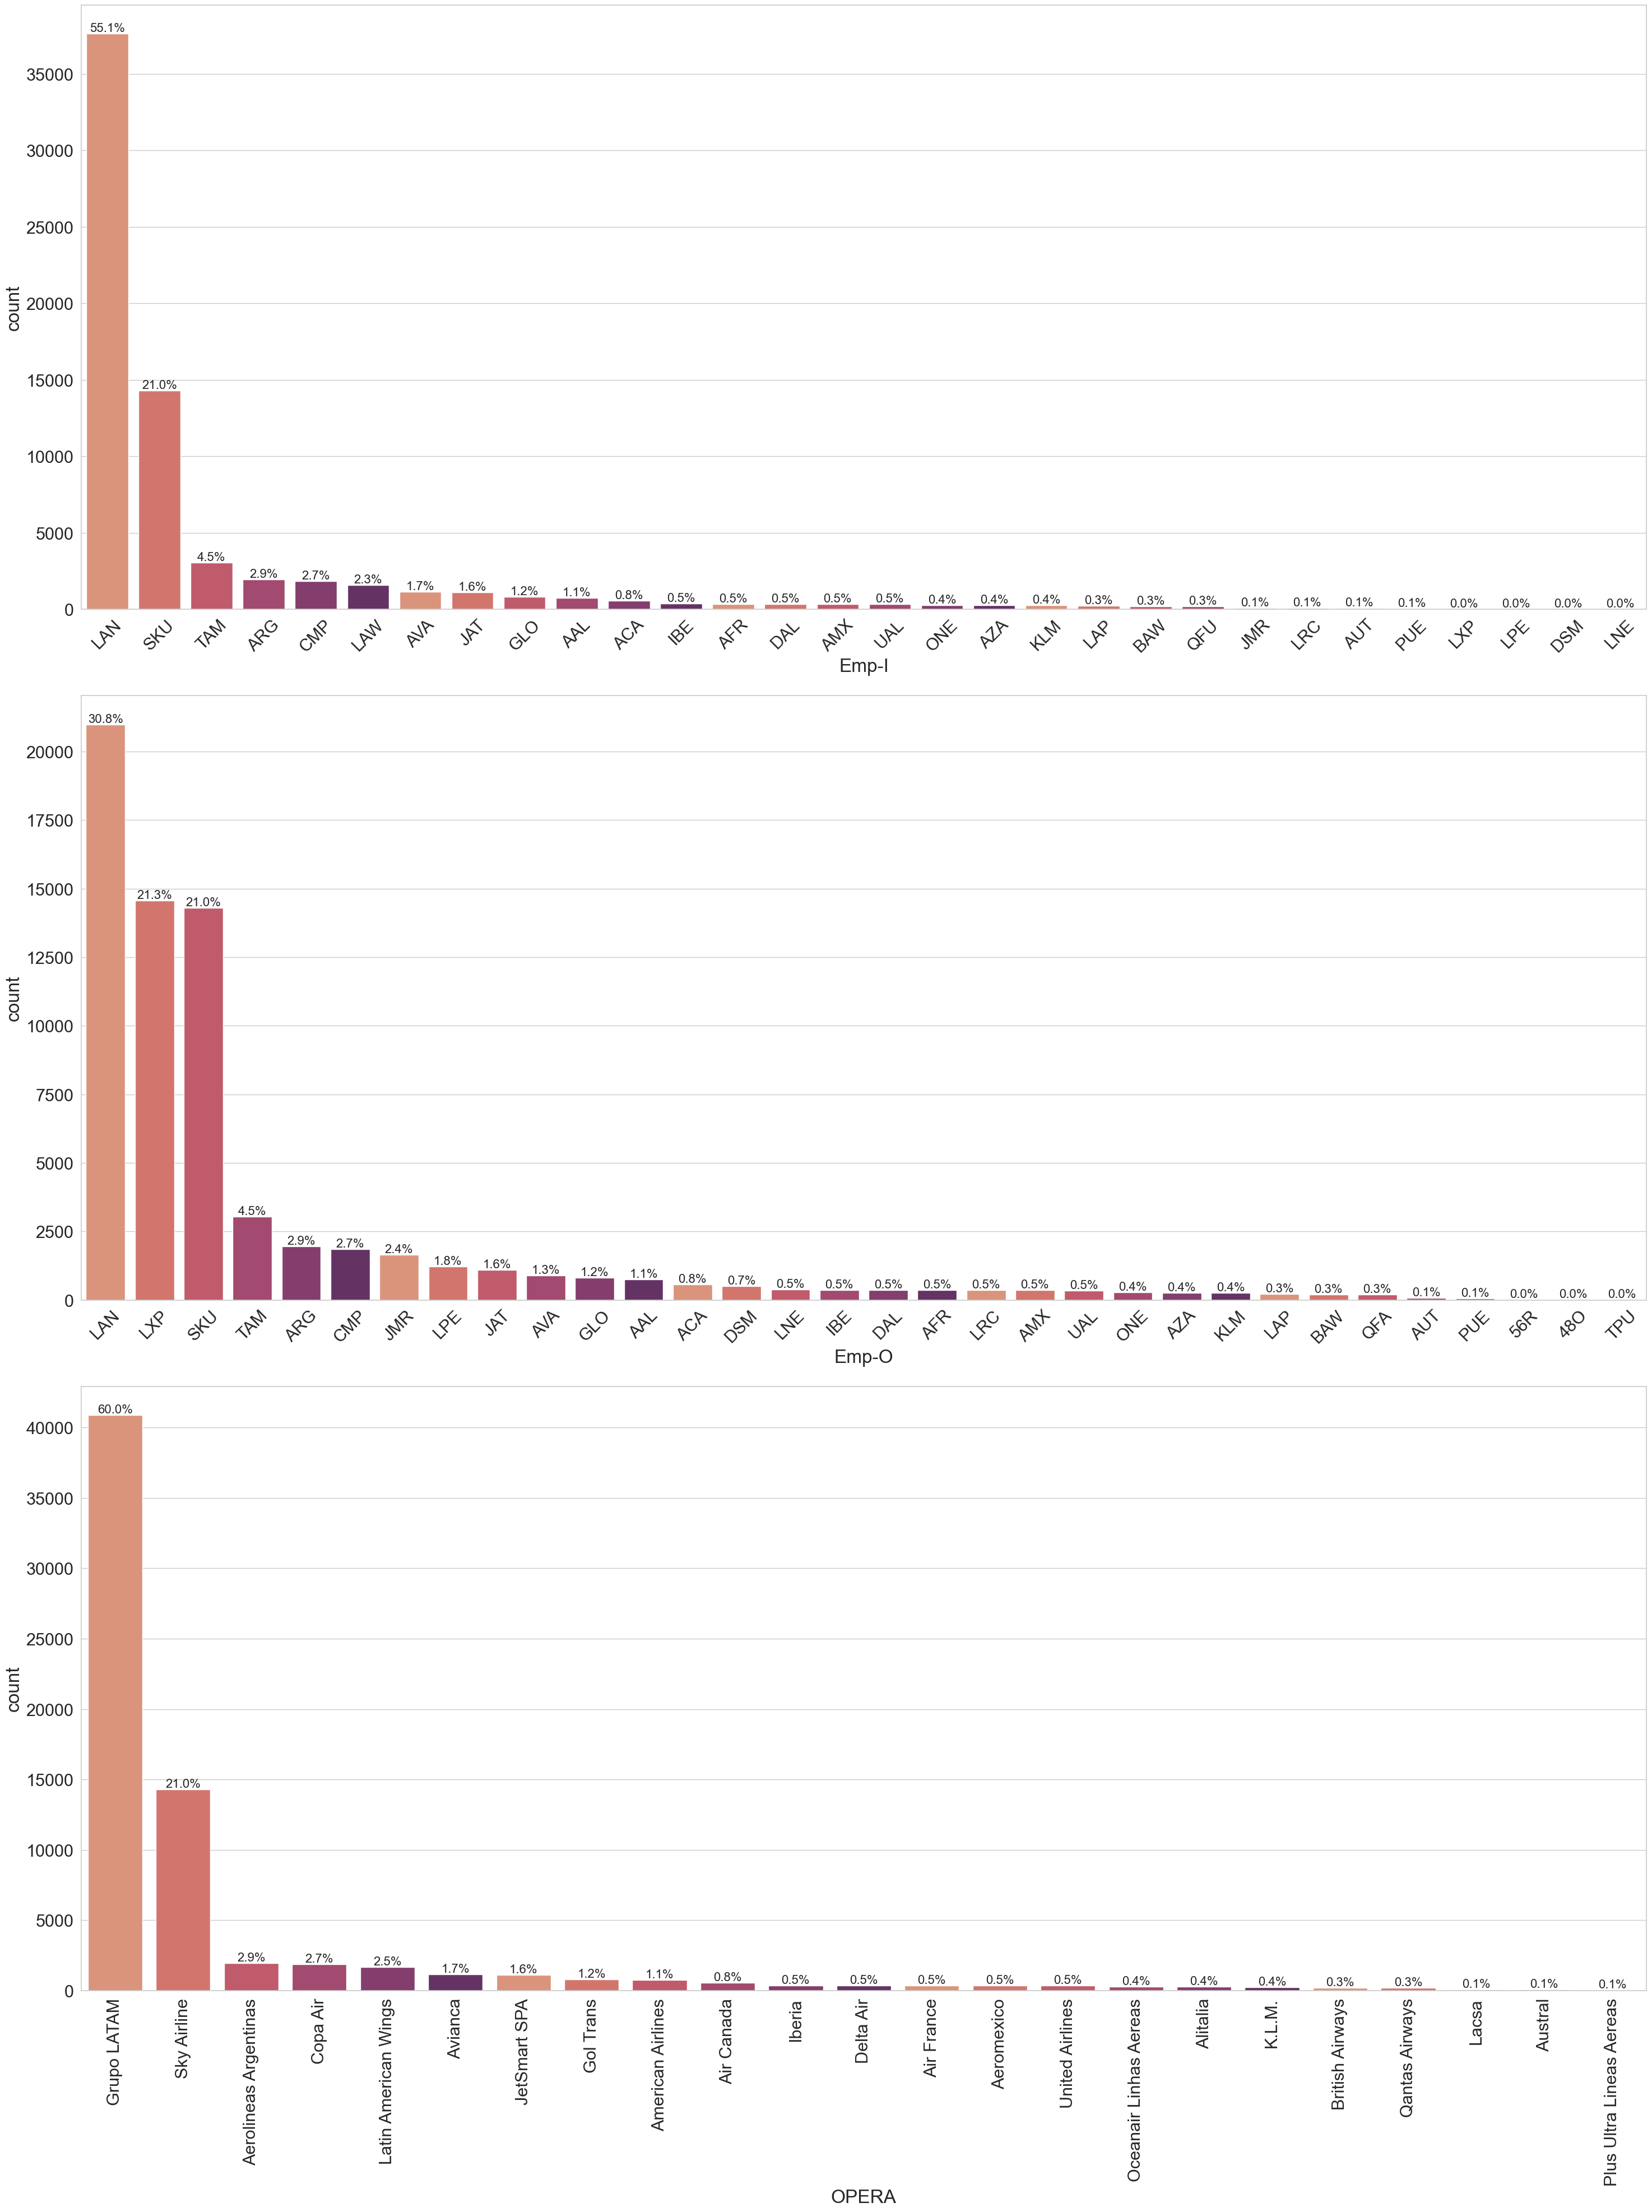

In [9]:
sns.set(rc={'figure.figsize':(30,40)})
sns.set_theme(style="whitegrid", font_scale=2)

categorical_vars = ['Emp-I','Emp-O','OPERA']
plt.figure()
i = 0
for cat in categorical_vars:
    plt.subplot(len(categorical_vars), 1, 1 + i)
    ax = sns.countplot(data=df, x=cat,palette = sns.color_palette("flare"),order = df[cat].value_counts().index)
    if cat == 'OPERA': r=90
    else: r = 45
    percentage_above_bar_relative_to_xgroup(ax,16)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

Sobre la distribución, se concluye que:
- Pocas aerolíneas (empresas/operadores) concentran la gran mayoría de los vuelos (Latam y Sky).
- Contrastando Emp-I con Emp-O, se observan 'traspasos' de vuelos entre empresas del mismo operador (ejemplo LAN-LXP).

Finalmente, se grafican las variables relacionadas a los destinos.

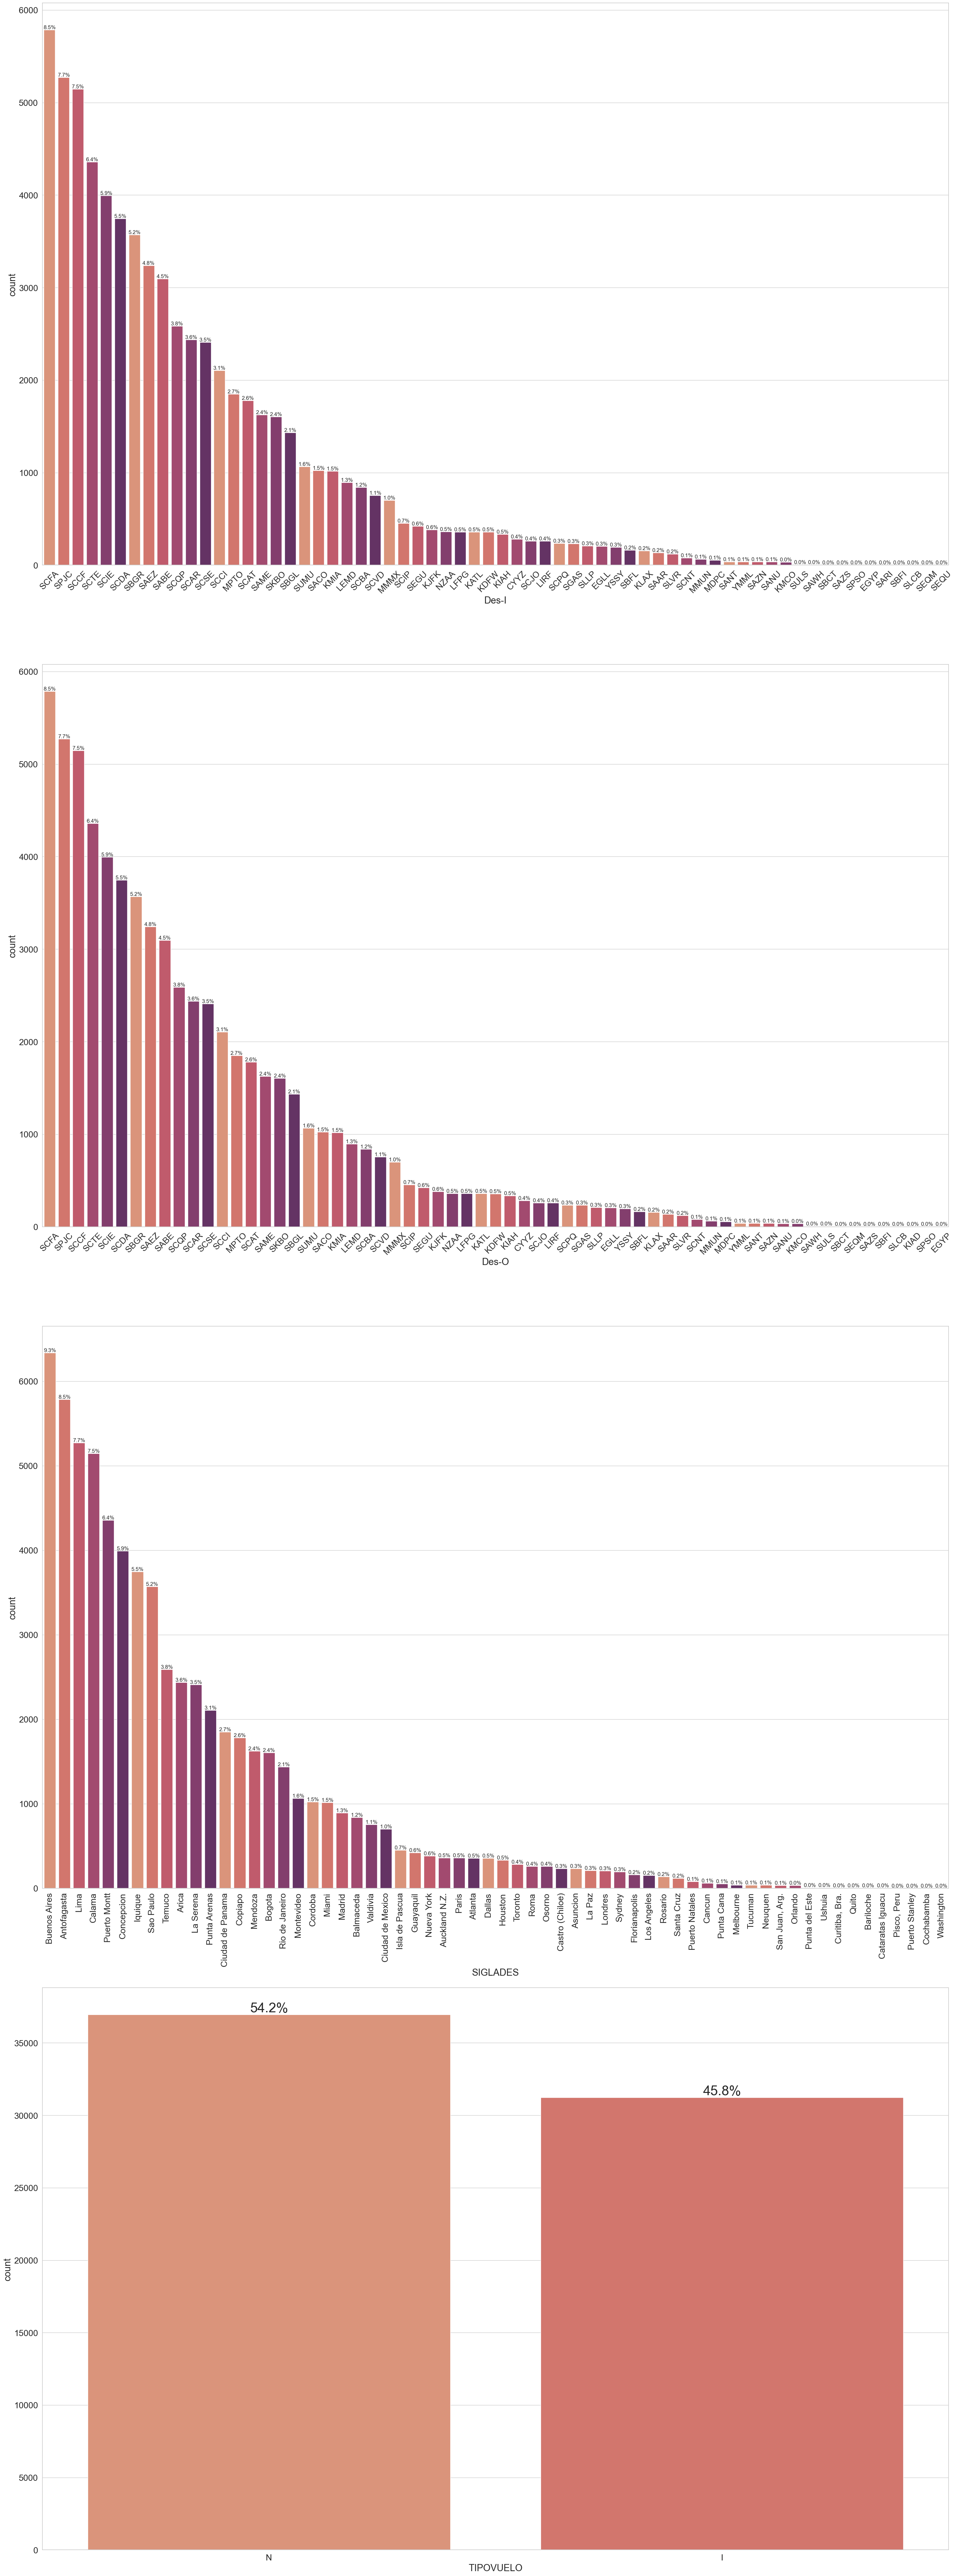

In [10]:
sns.set(rc={'figure.figsize':(30,80)})
sns.set_theme(style="whitegrid", font_scale=1.75)

categorical_vars = ['Des-I','Des-O','SIGLADES','TIPOVUELO']
plt.figure()
i = 0
for cat in categorical_vars:
    plt.subplot(len(categorical_vars), 1, 1 + i)
    ax = sns.countplot(data=df, x=cat,palette = sns.color_palette("flare"),order = df[cat].value_counts().index)
    if cat in ['Des-I','Des-O']: r, font_size = 45, 12
    elif cat in ['SIGLADES']: r, font_size = 90, 12
    else: r, font_size = 0, 30
    percentage_above_bar_relative_to_xgroup(ax,font_size)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

Se observa que:
- Las distribuciones Des-I y Des-O son prácticamente idénticas, confirmando que los cambios de destino son excepcionales.
- Los principales destinos son las ciudades de Buenos Aires, Antofagasta, Lima y Calama.
- Los vuelos nacionales/internacionales corresponden al 54.2%/45.8% respectivamente.

## Pregunta 2
**Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv**
<br>

Se procede a crear temporada_alta.

In [11]:
df['verano'] = pd.Series(dtype = int)
verano_mask = (df['Fecha-I'] >= '2017-12-15') | (df['Fecha-I'] <= '2017-03-03')
df.loc[verano_mask,'verano'] = 1
df['verano'] = df['verano'].fillna(0)

df['invierno'] = pd.Series(dtype = int)
invierno_mask = (df['Fecha-I'] >= '2017-07-15') & (df['Fecha-I'] <= '2017-07-31')
df.loc[invierno_mask,'invierno'] = 1
df['invierno'] = df['invierno'].fillna(0)

df['dieciocho'] = pd.Series(dtype = int)
dieciocho_mask = (df['Fecha-I'] >= '2017-09-11') & (df['Fecha-I'] <= '2017-09-30')
df.loc[dieciocho_mask,'dieciocho'] = 1
df['dieciocho'] = df['dieciocho'].fillna(0)

df['temporada_alta'] = (df['verano'] + df['invierno'] + df['dieciocho']).astype(int).astype('category')
df = df.drop(['verano','invierno','dieciocho'], axis = 1)

A continuación se construyen dif_min y atraso_15.

In [12]:
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds().div(60).astype(int)
df['atraso_15'] = np.where(df['dif_min']>15, 1, 0)

Finalmente se crea periodo_dia.

In [13]:
labels = ['noche','mañana', 'tarde', 'noche']
df['periodo_dia'] = pd.cut(df['Fecha-I'].dt.hour,[0, 5, 12, 19, 24],labels=labels, ordered = False, right=False)

Se guarda el nuevo archivo y se verifican los tipos de datos.

In [14]:
df.to_csv('synthetic_features.csv')
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].dtypes

Fecha-I           datetime64[ns]
Vlo-I                   category
Ori-I                   category
Des-I                   category
Emp-I                   category
Fecha-O           datetime64[ns]
Vlo-O                   category
Ori-O                   category
Des-O                   category
Emp-O                   category
DIA                     category
MES                     category
AÑO                     category
DIANOM                  category
TIPOVUELO               category
OPERA                   category
SIGLAORI                category
SIGLADES                category
temporada_alta          category
dif_min                    int64
atraso_15                  int64
periodo_dia             category
dtype: object

La variable atraso_15 se deja como int64, a pesar de ser conceptualmente categórica. Esto se debe a que el tipo int64 facilita los cálculos de la tasa de atraso. Se asume la definición de tasa de atraso como el porcentaje de los vuelos que sufrieron atraso. Esto es equivalente al promedio de la columna atraso_15.
<br>

A continuación, se realiza una inspección rápida de las nuevas variables.

In [15]:
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].describe(include='all',datetime_is_numeric=True)

,temporada_alta,dif_min,atraso_15,periodo_dia
count,68206.0,68206.000000,68206.000000,68206
unique,2.0,NaN,NaN,3
top,0.0,NaN,NaN,tarde
freq,45995.0,NaN,NaN,25506
mean,NaN,9.110855,0.184940,NaN
std,NaN,19.313387,0.388252,NaN
min,NaN,-14.000000,0.000000,NaN
25%,NaN,-1.000000,0.000000,NaN
50%,NaN,4.000000,0.000000,NaN
75%,NaN,12.000000,0.000000,NaN


Se concluye que:
- Ninguna variable nueva presenta datos faltantes.
- La tasa de atraso de todo el dataset es de 18.5%, por lo que el problema a resolver es de clasificación desbalanceada.

## Pregunta 3
**¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo
de vuelo?**
<br>

Para responder la pregunta, se procede a graficar la tasa de atraso por categoría. Se seleccionarán las categorías que puedan servir para la creación del modelo posterior. 
<br>

Por lo tanto, se desechan las variales tipo '-O', ya que se desconoce con cuánta anticipación se pueden obtener esos valores. Por ejemplo, un vuelo podría cambiar su Des-O por alguna emergencia una vez que ya ha despegado.
<br>

Por otro lado, se asumirá que la planificación de los vuelos ocurre con la antelación suficiente para permitir realizar las predicciones que se necesitan.

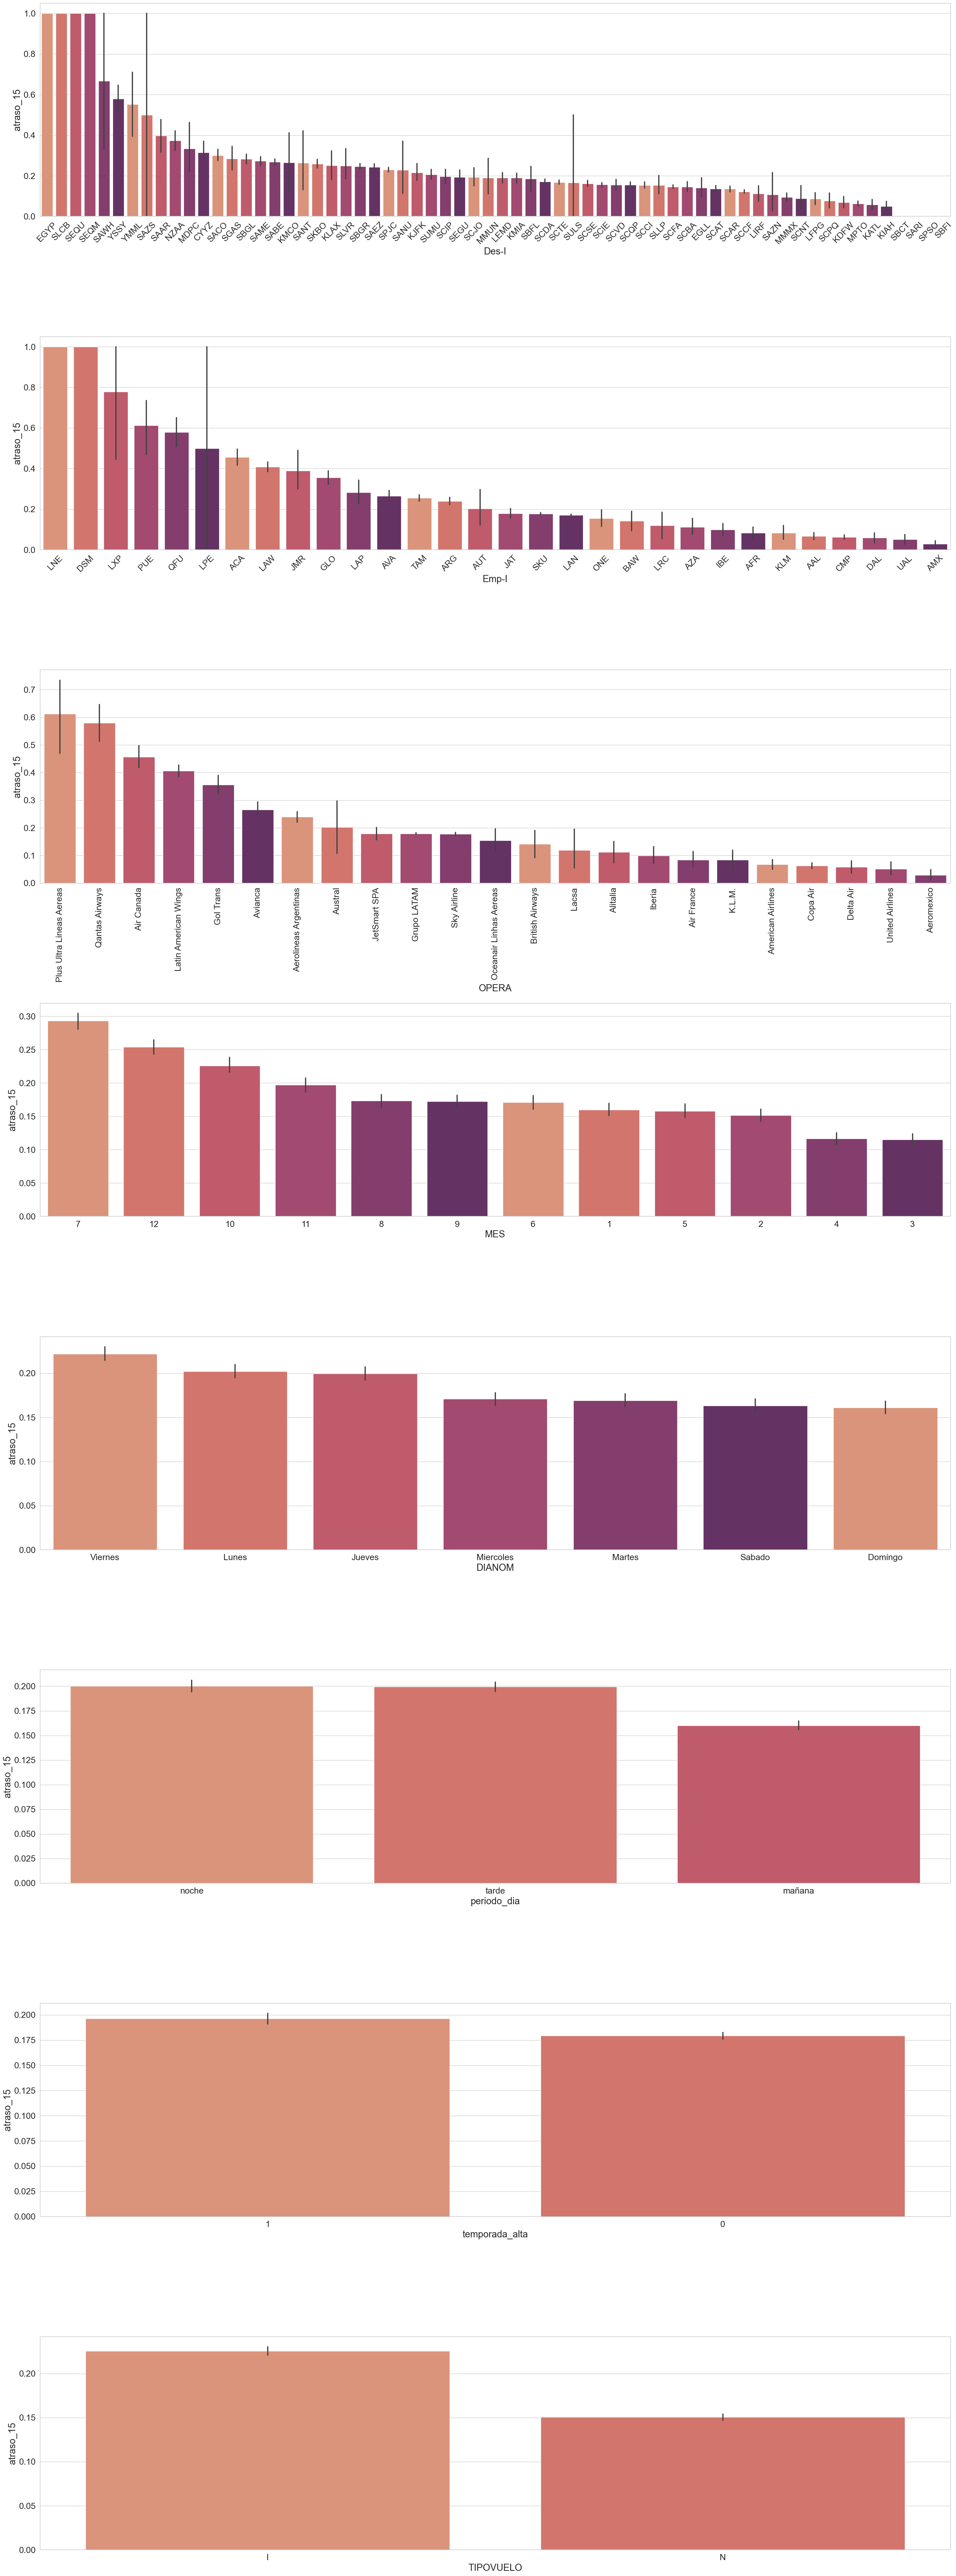

In [16]:
sns.set(rc={'figure.figsize':(30,80)})
sns.set_theme(style="whitegrid", font_scale=1.75)

_vars = ['Des-I','Emp-I','OPERA','MES','DIANOM','periodo_dia','temporada_alta','TIPOVUELO']
plt.figure()
i = 0
for cat in _vars:
    plt.subplot(len(_vars), 1, 1 + i)
    order = pd.pivot_table(data=df, index = cat)['atraso_15'].sort_values(ascending=False).index
    ax = sns.barplot(data=df, x = cat, y = 'atraso_15', order = order, palette = sns.color_palette("flare"))
    if cat in ['Des-I','Emp-I']: r = 45
    elif cat in ['OPERA']: r = 90    
    else: r = 0
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

**¿Qué variables esperarías que más influyeran en predecir atrasos?**
<br>

Aquellas variables que presentan distribuciones más alejadas de una homogénea, ya que dichas categorías entregan mayor información sobre la probabilidad de tener atrasos. Para este caso, serían:
- Des-I
- Emp-I
- OPERA
- MES
<br>

Sin embargo, Emp-I es una subcategoría de OPERA. En consecuencia, esta última es redundante.

## Pregunta 4
**Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso
de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.**
<br>

Una potencial causa de atrasos es la saturación del aeropuerto por alta cantidad de vuelos. Para capturar este efecto, se creará la variable num_vuelos, que corresponderá a la cuenta de vuelos planificados para una cierta fecha, periodo del día, empresa y destino.

In [17]:
df['num_vuelos'] = df.groupby(['MES','DIA','periodo_dia','Emp-I','Des-I'])['Vlo-I'].transform('count').astype(int)

df['num_vuelos'].describe()

count    68206.000000
mean         2.054687
std          1.275864
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: num_vuelos, dtype: float64

De la inspección rápida de la nueva variable, se observa:
- No hay faltantes.
- En promedio hay dos vuelos por mañana/noche/tarde hacia un mismo destino, por empresa.

Se procede a graficar las distribuciones resumidas en boxplots de la nueva variable, separadas por las clases sin y con atraso.

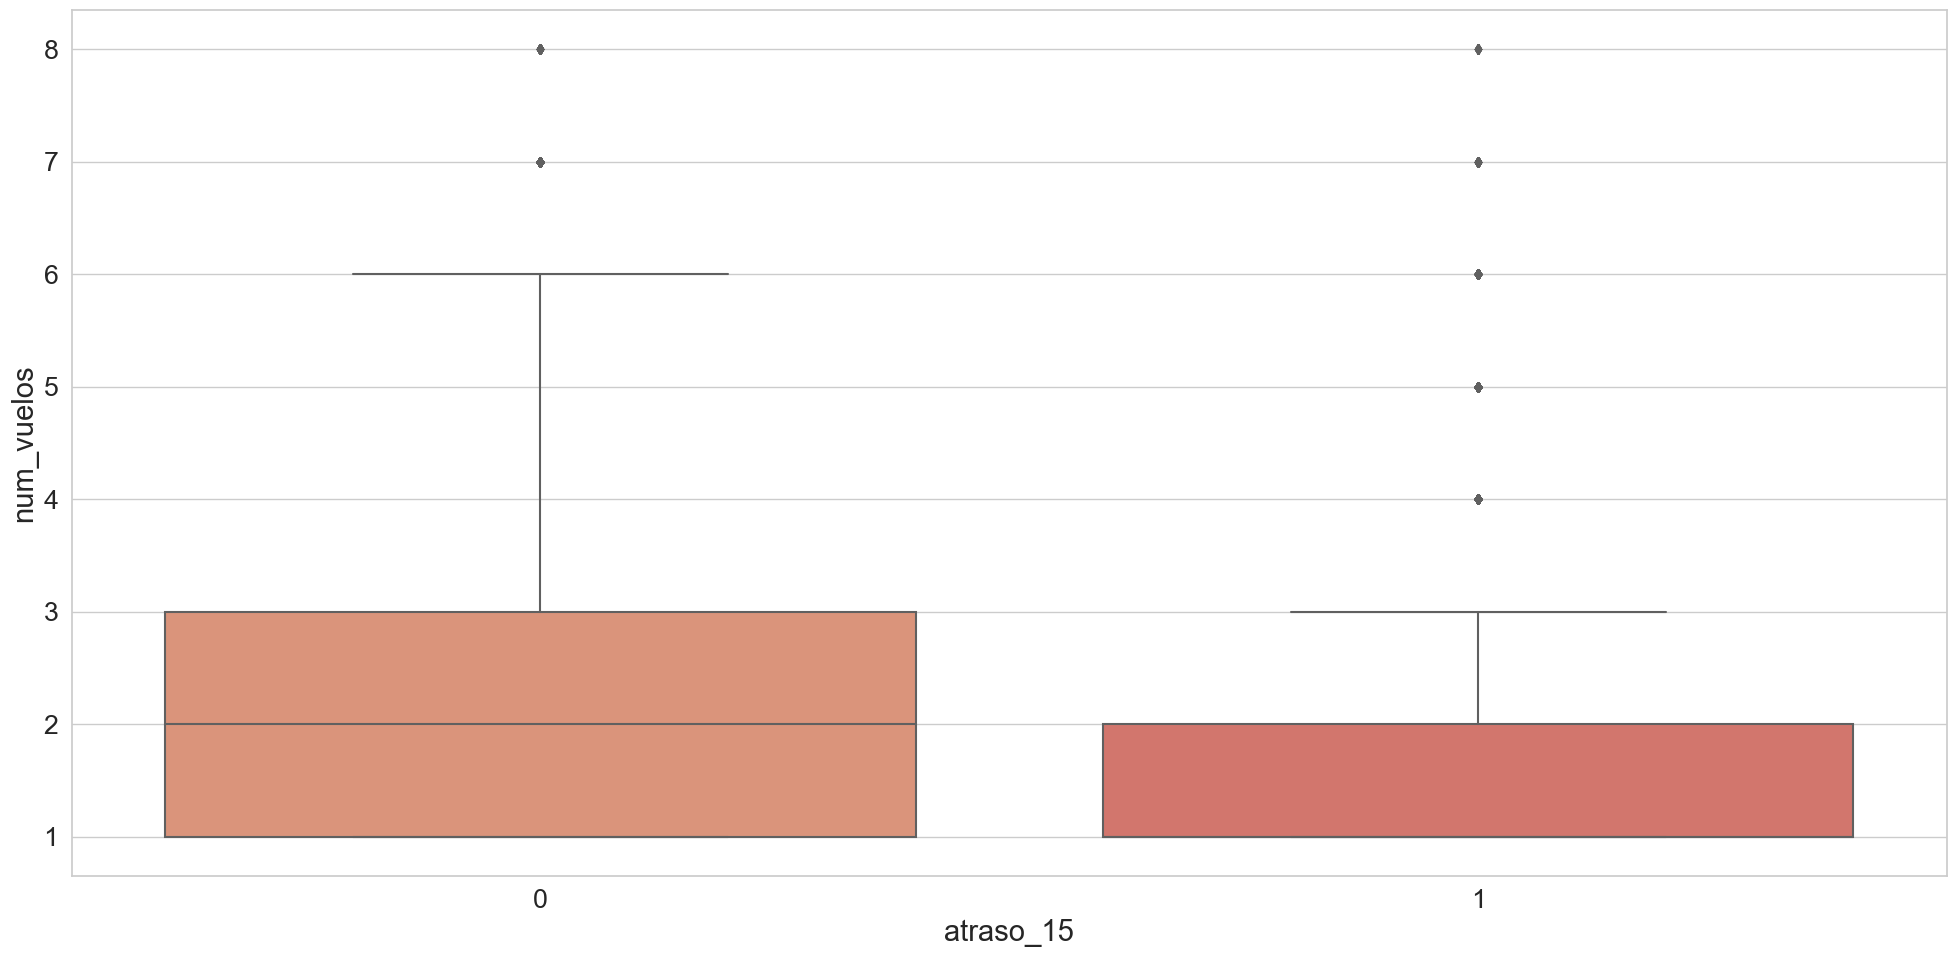

In [18]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid", font_scale=1.75)

sns.boxplot(data=df[['num_vuelos','atraso_15']], x='atraso_15', y='num_vuelos', palette = sns.color_palette("flare"))
plt.tight_layout()

Se observan diferencias entre las distribuciones para cada clase. En contraste a lo postulado, los vuelos con atraso suceden en momentos con menos vuelos planificados.
<br>

De acuerdo a lo comentado previamente, se utilizan como input las variables 'programadas' Des-I y Emp-I, las variables categóricas de fecha (originales y creadas) y la nueva variable num_vuelos.
<br>

Se separan los datos de testing (20% del dataset) para estimar la performance del modelo. Al ser un problema desbalanceado, la separación se hace con estratificación para mantener las proporciones de las clases en las separaciones del dataset. Se entrena un clasificador CatBoost usando validación cruzada de 3 folds, con búsqueda de hiperparámetros.


In [19]:
cat_features = ['Des-I', 'Emp-I', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'temporada_alta', 'periodo_dia']
features = cat_features + ['num_vuelos']
target = 'atraso_15'

x, x_test, y, y_test = train_test_split(df[features],df[target],test_size=0.2,random_state=42,stratify=df[target])


grid = {'learning_rate': [0.01, 0.03, 1],
        'depth': [6, 10, 14],
        'l2_leaf_reg': [5, 10, 15]}


model = catboost.CatBoostClassifier(cat_features=cat_features,early_stopping_rounds=15,verbose=100,allow_writing_files=False)
grid_search_result = model.grid_search(grid, X=x, y=y,cv=3)



0:	learn: 0.6883178	test: 0.6883578	best: 0.6883578 (0)	total: 81.5ms	remaining: 1m 21s
100:	learn: 0.4830555	test: 0.4841216	best: 0.4841216 (100)	total: 2.32s	remaining: 20.6s
200:	learn: 0.4448756	test: 0.4458405	best: 0.4458405 (200)	total: 4.39s	remaining: 17.5s
300:	learn: 0.4342606	test: 0.4353360	best: 0.4353360 (300)	total: 6.56s	remaining: 15.2s
400:	learn: 0.4290052	test: 0.4302850	best: 0.4302850 (400)	total: 8.55s	remaining: 12.8s
500:	learn: 0.4260913	test: 0.4277731	best: 0.4277731 (500)	total: 10.8s	remaining: 10.7s
600:	learn: 0.4244261	test: 0.4264530	best: 0.4264530 (600)	total: 12.8s	remaining: 8.51s
700:	learn: 0.4230448	test: 0.4254499	best: 0.4254499 (700)	total: 14.9s	remaining: 6.33s
800:	learn: 0.4218643	test: 0.4246650	best: 0.4246649 (799)	total: 16.8s	remaining: 4.18s
900:	learn: 0.4209402	test: 0.4241899	best: 0.4241899 (900)	total: 19.1s	remaining: 2.1s
999:	learn: 0.4200913	test: 0.4237745	best: 0.4237745 (999)	total: 21.2s	remaining: 0us

bestTest = 0.4

100:	learn: 0.4216255	test: 0.4313801	best: 0.4313801 (100)	total: 3.51s	remaining: 31.3s
200:	learn: 0.4024250	test: 0.4235749	best: 0.4235749 (200)	total: 8.47s	remaining: 33.7s
300:	learn: 0.3916010	test: 0.4217570	best: 0.4217479 (299)	total: 13.3s	remaining: 30.8s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.4207068236
bestIteration = 380

10:	loss: 0.4207068	best: 0.4204047 (1)	total: 3m 3s	remaining: 4m 26s
0:	learn: 0.4729379	test: 0.4775935	best: 0.4775935 (0)	total: 12.9ms	remaining: 12.9s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.4404398371
bestIteration = 7

11:	loss: 0.4404398	best: 0.4204047 (1)	total: 3m 4s	remaining: 3m 50s
0:	learn: 0.6883179	test: 0.6883578	best: 0.6883578 (0)	total: 10.5ms	remaining: 10.4s
100:	learn: 0.4796955	test: 0.4809788	best: 0.4809788 (100)	total: 2.95s	remaining: 26.2s
200:	learn: 0.4372283	test: 0.4405677	best: 0.4405677 (200)	total: 6.87s	remaining: 27.3s
300:	learn: 0.4232451	test: 0.430571

200:	learn: 0.4306292	test: 0.4411823	best: 0.4411823 (200)	total: 29.7s	remaining: 1m 58s
300:	learn: 0.4033747	test: 0.4290552	best: 0.4290552 (300)	total: 1m 3s	remaining: 2m 28s
400:	learn: 0.3851638	test: 0.4247766	best: 0.4247766 (400)	total: 1m 40s	remaining: 2m 30s
500:	learn: 0.3733886	test: 0.4231295	best: 0.4231295 (500)	total: 2m 14s	remaining: 2m 13s
600:	learn: 0.3638181	test: 0.4222952	best: 0.4222952 (600)	total: 2m 45s	remaining: 1m 49s
700:	learn: 0.3553247	test: 0.4217861	best: 0.4217861 (700)	total: 3m 15s	remaining: 1m 23s
800:	learn: 0.3473173	test: 0.4213900	best: 0.4213900 (800)	total: 3m 48s	remaining: 56.8s
900:	learn: 0.3397026	test: 0.4211794	best: 0.4211779 (899)	total: 4m 19s	remaining: 28.5s
999:	learn: 0.3313491	test: 0.4209918	best: 0.4209918 (999)	total: 4m 51s	remaining: 0us

bestTest = 0.4209917793
bestIteration = 999

24:	loss: 0.4209918	best: 0.4202425 (16)	total: 19m 51s	remaining: 1m 35s
0:	learn: 0.6788346	test: 0.6789549	best: 0.6789549 (0)	tot

Los hiperparámetros seleccionados para el modelo se muestran a continuación. El modelo fue reentrenado con los mejores parámetros.

In [20]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 15, 'learning_rate': 0.03}

## Pregunta 5
**Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué?**
<br>

Se utiliza el set de testing para evaluar la performance. Las métricas a utilizar son:
- Accuracy: Corresponde a la fracción de elementos bien clasificados. Se selecciona por su fácil interpretabilidad y por la existencia de un benchmark por defecto. Al ser un problema de clasificación desbalanceada, el modelo debe tener un Accuracy mejor a la fracción de la clase mayotitaria (81.5% para "No Atraso"), ya que un clasificador que siempre indique "No Atraso" tiene como base un Accuracy de 81.5%.
- Área bajo la curva ROC: El modelo originalmente entrega una probabilidad de que un vuelo sea "Atraso". Se debe definir un límite con el cual la probabilidad se encasilla como una de las dos clases. Por defecto, ese límite es 50%. Sin embargo, dependiendo de la criticidad de tener Falsos Positivos o Falsos Negativos, se puede seleccionar un límite distinto. La curva ROC mide la performance del modelo a medida que dicho límite se va modificando. Mientras mayor sea el área bajo ella, mejor es el modelo. Se selecciona esta métrica ya que entrega independencia del límite, logrando un modelo más versátil a las necesidades del negocio. Un benchmark para esta métrica es el valor de 0.5.

In [21]:
y_pred = model.predict(x_test)

print('Accuracy: ',np.round(accuracy_score(y_test,y_pred),3))
print('Área bajo la curva ROC: ',np.round(roc_auc_score(y_test,y_pred),3))

Accuracy:  0.828
Área bajo la curva ROC:  0.569


Se observa que las métricas son ligeramente mejores que los benchmark.

**¿Por qué elegiste ese algoritmo en particular?**
<br>

Se escoge el algoritmo CatBoost que está basado en árboles de decisión, y utiliza GradientBoosting. Los métodos de GradientBoosting tienen en general mejor performance en data heterogénea (a diferencia de las redes neuronales, que funcionan mejor en data homogénea, como imágenes o audio). Adicionalmente, CatBoost contempla el uso de variables categóricas de manera eficiente y sencilla (corresponde al origen del nombre del algoritmo).

**¿Qué variables son las que más influyen en la predicción?**
<br>

Para determinar la influencia de las variables, se calcularán los valores de SHAP, el cual corresponde a un algoritmo obtenido del estudio de teoría de juegos. El algoritmo SHAP intenta emular el modelo original para poder explicar la influencia de sus variables en las predicciones. A partir del valor esperado para la predicción (promedio del dataset), los valores de SHAP de cada variable van modificando de forma aditiva la predicción, hasta llegar al valor final. Por lo tanto, mientras mayor sea el promedio del valor absoluto de los valores de SHAP de una variable, más influye en la predicción final.

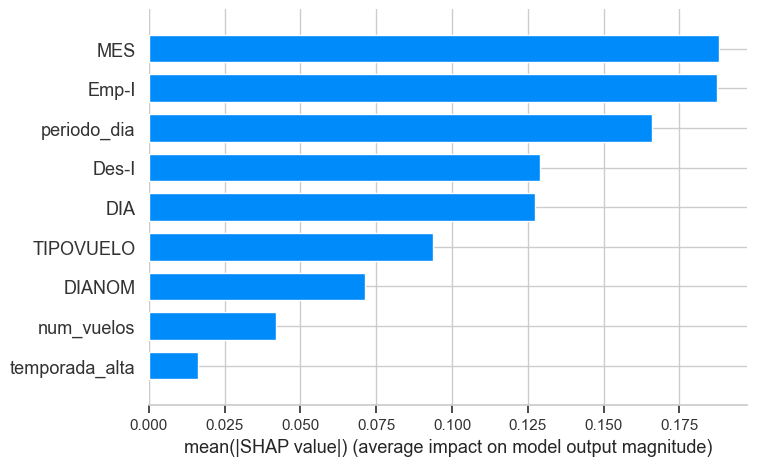

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

En el gráfico se encuentran ordenadas las variables, de más a menos importantes.

**¿Cómo podrías mejorar la performance?**
<br>

Se proponen las siguientes ideas:
- Consultar directamente a cliente por posibles causas de atrasos, aprovechando su entendimiento del negocio. Intentar reflejar dichas causas en variables.
- Integrar información extra. Por ejemplo, APIs con posicionamiento en tiempo real de aviones, predicciones del clima, feriados.
- Probar con variables de series de tiempo, por ejemplo la cuenta de atrasos que tuvo una aeroínea los días anteriores. Verificar en un diagrama de autocorrelación si existen lags relevantes.
- Agregar más años a los datos, para capturar de mejor manera las estacionalidades.